Ref: https://datahack.analyticsvidhya.com/contest/wns-analytics-wizard-2019/?utm_source=auto-email

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import SCORERS

%matplotlib inline

In [2]:
train_data = pd.read_csv("train.csv")
logs_data = pd.read_csv("view_log.csv")
item_data = pd.read_csv("item_data.csv")
test_data = pd.read_csv("test.csv")

In [3]:
%%time
pandas_profiling.ProfileReport(train_data)

Wall time: 1min 34s


In [5]:
logs_data["server_time"] = pd.to_datetime(logs_data["server_time"])
train_data["impression_time"] = pd.to_datetime(train_data["impression_time"])
test_data["impression_time"] = pd.to_datetime(test_data["impression_time"])

### Merge Train and Test Data for feature engineering
train_data["train_flag"] = 1
test_data["train_flag"] = 0
conversion_labels = train_data[["impression_id", "is_click"]]
full_data = pd.concat([train_data.drop(columns="is_click"), test_data])



In [13]:
user_logs = pd.merge(logs_data, item_data)

In [86]:
# Extracting datetime related features. 

train_data["impression_hour"] = train_data["impression_time"].apply(lambda x:x.hour)
train_data["impression_date"] = train_data["impression_time"].apply(lambda x:str(x.date()))
train_data["impression_dayofweek"] = train_data["impression_time"].apply(lambda x:x.dayofweek)
train_data["impression_day"] = train_data["impression_time"].apply(lambda x:x.day)




test_data["impression_hour"] = test_data["impression_time"].apply(lambda x:x.hour)
test_data["impression_date"] = test_data["impression_time"].apply(lambda x:str(x.date()))
test_data["impression_dayofweek"] = test_data["impression_time"].apply(lambda x:x.dayofweek)
test_data["impression_day"] = test_data["impression_time"].apply(lambda x:x.day)

logs_data["hour"] = logs_data["server_time"].apply(lambda x:x.hour)
logs_data["day"] = logs_data["server_time"].apply(lambda x:x.day)
logs_data["dayofweek"] = logs_data["server_time"].apply(lambda x:x.dayofweek)
logs_data["date"] = logs_data["server_time"].apply(lambda x:str(x.date()))

In [20]:
logs_data.head()

server_time device_type  session_id  user_id  item_id
0 2018-10-15 08:58:00     android      112333     4557    32970
1 2018-10-15 08:58:00     android      503590    74788     7640
2 2018-10-15 08:58:00     android      573960    23628   128855
3 2018-10-15 08:58:00     android      121691     2430    12774
4 2018-10-15 08:58:00     android      218564    19227    28296

In [36]:
full_data.head()

impression_id     impression_time  user_id  app_code  \
0  c4ca4238a0b923820dcc509a6f75849b 2018-11-15 00:00:00    87862       422   
1  45c48cce2e2d7fbdea1afc51c7c6ad26 2018-11-15 00:01:00    63410       467   
2  70efdf2ec9b086079795c442636b55fb 2018-11-15 00:02:00    71748       259   
3  8e296a067a37563370ded05f5a3bf3ec 2018-11-15 00:02:00    69209       244   
4  182be0c5cdcd5072bb1864cdee4d3d6e 2018-11-15 00:02:00    62873       473   

     os_version  is_4G  train_flag  
0           old      0           1  
1        latest      1           1  
2  intermediate      1           1  
3        latest      1           1  
4        latest      0           1

In [91]:
# Checking if all users and apps of test are also present in train data
len([u for u in test_data["user_id"].unique() if u not in train_data["user_id"].unique()])

14434

In [92]:
len(test_data["user_id"].unique())

34079

In [93]:
# Checking if all users and apps of test are also present in train data
len([u for u in test_data["app_code"].unique() if u not in train_data["app_code"].unique()]), len(test_data["app_code"].unique())

(32, 373)

1/3rd of the users from test data are not present in train data. Also 10% of apps in test data are not found in train data. A better initial set of models could focus less on the user's past click conversions and more on the user log activity

In [54]:
item_data.shape

(132761, 6)

In [408]:
logs_data.head()

server_time device_type  session_id  user_id  item_id
0 2018-10-15 08:58:00     android      112333     4557    32970
1 2018-10-15 08:58:00     android      503590    74788     7640
2 2018-10-15 08:58:00     android      573960    23628   128855
3 2018-10-15 08:58:00     android      121691     2430    12774
4 2018-10-15 08:58:00     android      218564    19227    28296

In [6]:
item_data.head()

item_id  item_price  category_1  category_2  category_3  product_type
0    26880        4602          11          35          20          3040
1    54939        3513          12          57          85          6822
2    40383         825          17           8         279          1619
3     8777        2355          13          58         189          5264
4   113705        1267          17          39         151         10239

In [12]:
logs_data["device_type"].value_counts()

android    3117737
iphone         861
web             24
Name: device_type, dtype: int64

In [13]:
%%time
pandas_profiling.ProfileReport(item_data)

Wall time: 3min 37s


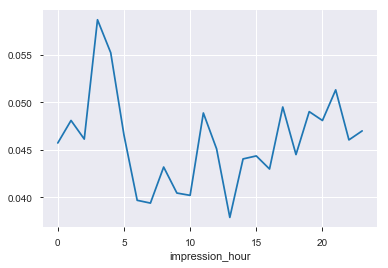

In [35]:
pd.crosstab( train_data["is_click"], train_data["impression_hour"], normalize="columns").loc[1].plot()

In [18]:
pd.crosstab(train_data["os_version"], train_data["is_click"], normalize="index")

is_click             0         1
os_version                      
intermediate  0.948238  0.051762
latest        0.958349  0.041651
old           0.950710  0.049290

In [17]:
logs_data[logs_data["user_id"]==63410]

server_time device_type  session_id  user_id  item_id
284024  2018-10-21 06:13:00     android      356854    63410    43209
284028  2018-10-21 06:13:00     android      356854    63410    66370
309046  2018-10-21 17:01:00     android      345289    63410    43209
339224  2018-10-22 09:54:00     android      406658    63410    43209
449354  2018-10-24 11:14:00     android       15568    63410    71877
486317  2018-10-25 05:00:00     android      343558    63410    43209
486325  2018-10-25 05:03:00     android      343558    63410    43209
2115995 2018-11-24 05:29:00     android      983607    63410    97274
3028698 2018-12-10 19:48:00     android      135003    63410   109074
3028895 2018-12-10 19:51:00     android      135003    63410    58018
3029399 2018-12-10 19:59:00     android      135003    63410   109074
3029745 2018-12-10 20:03:00     android      135003    63410    22064

In [61]:
np.percentile(train_data["user_id"].value_counts(),[10,20,50,75,90,95,99])

array([ 1.,  1.,  2.,  3.,  7., 11., 25.])

In [25]:
logs_data.groupby("user_id")["device_type"].nunique().value_counts()

1    89075
2       82
Name: device_type, dtype: int64

Only 82 users of total 90k users have two devices Rest all have one device only

Whether a user clicked on the ad may depend on:
1. user's previous clicks -> a user-item matrix type of framework with recommended ads
2. app_code -> some apps show better targeted ads?
3. How recently did users browse some products? -> within prev x(=1,2,3,7) days
4. How many sessions did the users have in recent x(=1,2,3,7) days?
5. What's the users' most active time of day? -> For browsing, for ads, and what's current ad showing time?
6. 

In [37]:
user_logs.head()

server_time device_type  session_id  user_id  item_id  item_price  \
0 2018-10-15 08:58:00     android      112333     4557    32970       54685   
1 2018-10-15 09:36:00     android      783457    88320    32970       54685   
2 2018-10-15 10:59:00     android        6902     1711    32970       54685   
3 2018-10-15 11:31:00     android       61138    58906    32970       54685   
4 2018-10-15 12:03:00     android      441653    64221    32970       54685   

   product_type  category_1_0  category_1_1  category_1_2       ...        \
0          3184             0             0             0       ...         
1          3184             0             0             0       ...         
2          3184             0             0             0       ...         
3          3184             0             0             0       ...         
4          3184             0             0             0       ...         

   category_3_332  category_3_333  category_3_334  category_3_335  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   category_3_336  category_3_337  category_3_338  category_3_339  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   category_3_340  category_3_341  
0               0               0  
1               0               0  
2               0               0  
3               0               0  
4               0               0  

[5 rows x 438 columns]

In [72]:
user_logs.head().groupby(["session_id", "user_id"]).agg({"category_1":lambda x: list(x)})["category_1"]

session_id  user_id
6902        1711       [16]
61138       58906      [16]
112333      4557       [16]
441653      64221      [16]
783457      88320      [16]
Name: category_1, dtype: object

In [65]:
user_logs.head().groupby(["session_id", "user_id"])["category_1"].apply(list)

session_id  user_id
6902        1711       [16]
61138       58906      [16]
112333      4557       [16]
441653      64221      [16]
783457      88320      [16]
Name: category_1, dtype: object

In [140]:
session_aggregation = user_logs.groupby(["session_id", "user_id"]).agg({"item_price":[np.mean, np.max,np.min],
                                                                       "item_id": pd.Series.nunique,
                                                                               "category_1": lambda x: list(x),
                                                                               "category_2":lambda x: list(x),
                                                                               "category_3":lambda x: list(x),
                                                                              "product_type":lambda x: list(x),
                                                                              })

session_aggregation["mean_item_price"]=session_aggregation["item_price"]["mean"]
session_aggregation["min_item_price"]=session_aggregation["item_price"]["amin"]
session_aggregation["max_item_price"]=session_aggregation["item_price"]["amax"]
session_aggregation["items"]=session_aggregation["item_id"]["nunique"]
session_aggregation["category1"]=session_aggregation["category_1"]#["nunique"]
session_aggregation["category2"]=session_aggregation["category_2"]#["nunique"]
session_aggregation["category3"]=session_aggregation["category_3"]#["nunique"]
session_aggregation["product_type"]=session_aggregation["product_type"]#["nunique"]

session_aggregation= (session_aggregation
                      .reset_index()[["session_id", "user_id", "items",
                                      "mean_item_price", "min_item_price", "max_item_price",
                                      "category1", "category2", "category3", "product_type"]])

session_aggregation.columns= session_aggregation.columns.get_level_values(0)

session_duration = user_logs.groupby(["session_id", "user_id"]).agg({"server_time":[np.max,np.min]})
session_duration["sess_len"] = session_duration["server_time"]["amax"] - session_duration["server_time"]["amin"]
session_duration = session_duration[[("server_time", "amax"), ("sess_len","")]]
session_duration.columns = session_duration.columns.get_level_values(0)
session_duration= session_duration.reset_index()

In [143]:
session_aggregation = pd.merge(user_logs[["session_id", "user_id", "device_type"]].drop_duplicates(),
                               session_aggregation, 
                               left_on=["session_id", "user_id"], 
                               right_on=["session_id", "user_id"])

session_aggregation = pd.merge(session_aggregation, session_duration, on=["session_id", "user_id"])

# Feature engineering
1. For a given impression, no:of product views of the user - till that point, in prev hour, prev day, prev 2/3/7 days
2. For a given impression, max no:of same product views of a user in previous hour, prev day, prev 2/3/7 days
3. For a given impression, time elapsed from most recent product view of a user
4. For a given impression, no:of impressions and clicks of the user till that point
5. For a given impression, ctr of user till that point
6. 

Joining on the session aggregation, so product category level info is gone. 

In [147]:
feature_data_outer = pd.merge(full_data, session_aggregation, how="left", on="user_id")

feature_data_filtered = feature_data_outer[feature_data_outer["server_time"]<feature_data_outer["impression_time"]]
del feature_data_outer

feature_data_filtered["product_time_lag"] = feature_data_filtered["impression_time"] - feature_data_filtered["server_time"]

In [138]:
conversion_labels[conversion_labels["impression_id"] == "45c48cce2e2d7fbdea1afc51c7c6ad26"]

impression_id  is_click
1  45c48cce2e2d7fbdea1afc51c7c6ad26         1

In [83]:
def flatten_list(list_of_list):
    flat_list=[]
    for list_ in list_of_list:
        flat_list.extend(list_)
    return flat_list

def list_count(list_):
    """
    Returns length of list, and count of unique elements in the list
    """
    return len(list_), len(set(list_))

In [84]:
list_count(flatten_list([[1,2],[3,4,4,2]]))

(6, 4)

In [85]:
feature_data_filtered.head().groupby("user_id").agg({"category1":lambda x:list_count(flatten_list(list(x))),
                                                     "category2":lambda x:list_count(flatten_list(list(x))),
                                                    "server_time"})

category1 category2
user_id                    
63410      (6, 2)    (6, 2)
87862      (1, 1)    (1, 1)

For a given impression_time, there can be multiple previous sessions of the same user. We need to aggregate those as well. 
### Aggregations:
1. Time from most recent session
2. No:of previous sessions
3. Total products viewed across all sessions
4. No:of products viewed in recent session
5. No:of products viewed in recent 1/2/3/7/14/21/30 days
6. 

In [166]:
most_recent_session = feature_data_filtered.groupby(["impression_id", "user_id"])["server_time"].max()
most_recent_session = pd.DataFrame(most_recent_session).reset_index().rename(columns={"server_time":"recent_time"})

feature_data_filtered = feature_data_filtered.merge(most_recent_session,on=["impression_id", "user_id"] )
feature_data_filtered["recent_session_flag"]=feature_data_filtered.apply(lambda x:1 if x["recent_time"]==x["server_time"] else 0, axis=1)

In [171]:
sessions_aggregate_features = feature_data_filtered.groupby(["impression_id", "user_id"]).agg({"max_item_price":"max",
                                                                                               "category1":lambda x:list_count(flatten_list(list(x))),
                                                                                               "category2":lambda x:list_count(flatten_list(list(x))),
                                                                                               "category3":lambda x:list_count(flatten_list(list(x))),
                                                                                               "product_type":lambda x:list_count(flatten_list(list(x))),
                                                                                               "items":{"sum", "max"},
                                                                                               "mean_item_price":"mean",
                                                                                               "sess_len":"max",
                                                                                               "session_id":"size"})

In [178]:
sessions_aggregate_features["max_item_price_agg"] = sessions_aggregate_features["max_item_price"]["max_item_price"]
sessions_aggregate_features["category1_agg"] = sessions_aggregate_features["category1"]["category1"]
sessions_aggregate_features["category2_agg"] = sessions_aggregate_features["category2"]["category2"]
sessions_aggregate_features["category3_agg"] = sessions_aggregate_features["category3"]["category3"]
sessions_aggregate_features["product_type_agg"] = sessions_aggregate_features["product_type"]["product_type"]
sessions_aggregate_features["items_total"] = sessions_aggregate_features["items"]["sum"]
sessions_aggregate_features["max_items"] = sessions_aggregate_features["items"]["max"]

sessions_aggregate_features["mean_item_price_agg"] = sessions_aggregate_features["mean_item_price"]["mean_item_price"]
sessions_aggregate_features["sess_len_max"] = sessions_aggregate_features["sess_len"]["sess_len"]
sessions_aggregate_features["sessions_cnt"] = sessions_aggregate_features["session_id"]["session_id"]

sessions_aggregate_features = sessions_aggregate_features.reset_index()
sessions_aggregate_features = sessions_aggregate_features[["impression_id", "user_id", "max_item_price_agg", "category1_agg", "category2_agg", "category3_agg",
                                                        "product_type_agg","items_total", "max_items", "mean_item_price_agg", "sess_len_max", "sessions_cnt"]]

sessions_aggregate_features.columns = sessions_aggregate_features.columns.get_level_values(0)

In [180]:
sessions_aggregate_features.head()

impression_id  user_id  max_item_price_agg  \
0  00003e3b9e5336685200ae85d21b4f5e    38051              2298.0   
1  000053b1e684c9e7ea73727b2238ce18    65897             18496.0   
2  00005d011db80a956aab176cc94d1d37     4842             58307.0   
3  0000b2815cc3c2b56867cbbf4d36efa5    16990             40642.0   
4  000109e6bf54b3b20e8547b6026bc355    50523            101235.0   

  category1_agg category2_agg category3_agg product_type_agg  items_total  \
0        (7, 3)        (7, 3)        (7, 4)           (7, 4)          5.0   
1        (3, 3)        (3, 3)        (3, 3)           (3, 3)          3.0   
2      (42, 13)      (42, 20)      (42, 21)         (42, 26)         30.0   
3       (24, 7)      (24, 11)      (24, 12)         (24, 13)         16.0   
4       (20, 9)      (20, 12)      (20, 13)         (20, 14)         15.0   

   max_items  mean_item_price_agg sess_len_max  sessions_cnt  
0        2.0           934.125000     00:09:00             4  
1        2.0          8321.500000     00:01:00             2  
2       21.0          2371.272727     01:01:00             9  
3        3.0         14490.704545     00:09:00            11  
4        4.0         17990.333333     00:29:00             9

In [181]:
recent_session_features = feature_data_filtered[feature_data_filtered["recent_session_flag"]==1]

In [247]:
recent_session_features.drop(columns=["impression_time",  "server_time", "recent_time", "category1", "category2","category3", "product_type", "sess_len", "product_time_lag"]).head()

impression_id  user_id  app_code    os_version  is_4G  \
0   c4ca4238a0b923820dcc509a6f75849b    87862       422           old      0   
5   45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467        latest      1   
6   70efdf2ec9b086079795c442636b55fb    71748       259  intermediate      1   
7   8e296a067a37563370ded05f5a3bf3ec    69209       244        latest      1   
14  182be0c5cdcd5072bb1864cdee4d3d6e    62873       473        latest      0   

    train_flag  session_id device_type  items  mean_item_price  \
0            1    190710.0     android    1.0           2350.0   
5            1    343558.0     android    1.0           3421.0   
6            1    658178.0     android    1.0            973.0   
7            1    358781.0     android    4.0           2595.0   
14           1    809094.0     android    1.0           4556.0   

    min_item_price  max_item_price  recent_session_flag  
0           2350.0          2350.0                    1  
5           3421.0          3421.0                    1  
6            973.0           973.0                    1  
7            249.0          7320.0                    1  
14          4556.0          4556.0                    1

In [198]:
def mode_of_list(list_):
    max_freq=0
    pop_item = list_[0]
    for e in list_:
        freq = list_.count(e)
        if freq > max_freq:
            max_freq = freq
            pop_item = e
    return pop_item

In [241]:
recent_session_features1_ = recent_session_features.apply({"category1":lambda x:mode_of_list(x),
                                                           "category2":lambda x:mode_of_list(x),
                                                           "category3":lambda x:mode_of_list(x),
                                                           "product_type":lambda x:mode_of_list(x),
                                                           "sess_len":lambda x:x.seconds,
                                                           "impression_time":lambda x:x.dayofweek,
                                                           "product_time_lag":lambda x:x.days})

recent_session_features2_ = recent_session_features.apply({"category1":lambda x:list_count(x),
                                                          "category2":lambda x:list_count(x),
                                                          "category3":lambda x:list_count(x),
                                                          "product_type":lambda x:list_count(x),
                                                          "impression_time":lambda x:x.hour,
                                                          "product_time_lag":lambda x:x.total_seconds()/60})

recent_session_features1_=recent_session_features1_.rename(columns={"category1":"pop_cat1",
                                 "category2":"pop_cat2",
                                 "category3":"pop_cat3",
                                 "product_type":"pop_product",
                                 "sess_len":"sess_len_sec",
                                 "impression_time":"imp_day_of_week",
                                 "product_time_lag":"last_seen_days"})

for col_ in ["category1", "category2", "category3", "product_type"]:
    recent_session_features2_[col_+"_cnt"] = recent_session_features2_[col_].apply(lambda x:x[0])
    recent_session_features2_[col_+"_nunique"] = recent_session_features2_[col_].apply(lambda x:x[1])
    recent_session_features2_ = recent_session_features2_.drop(columns=col_)

recent_session_features2_ = recent_session_features2_.rename(columns={"impression_time":"imp_hour",
                                                                      "prduct_time_lag":"last_seen_mins"})

In [243]:
recent_session_features1_.head()

pop_cat1  pop_cat2  pop_cat3  pop_product  sess_len_sec  imp_day_of_week  \
0         11        35        20         5622             0                3   
5          4        74       292          577           180                3   
6         13        67       170         2874             0                3   
7         14        61       159         7093          1020                3   
14         7        24       100         9215             0                3   

    last_seen_days  
0               26  
5               20  
6               22  
7                0  
14               0

In [250]:
recent_session_features_extracted = (pd.merge(recent_session_features.drop(columns=["impression_time",  "server_time", "recent_time",
                                                "category1", "category2","category3", "product_type",
                                                "sess_len", "product_time_lag"]),
                                              pd.merge(recent_session_features1_, recent_session_features2_, left_index=True, right_index=True), 
                                              left_index=True, right_index=True))

In [257]:
for col_ in ["category1", "category2", "category3", "product_type"]:
    sessions_aggregate_features[col_+"_agg_cnt"] = sessions_aggregate_features[col_+"_agg"].apply(lambda x:x[0])
    sessions_aggregate_features[col_+"_agg_nunique"] = sessions_aggregate_features[col_+"_agg"].apply(lambda x:x[1])
    sessions_aggregate_features = sessions_aggregate_features.drop(columns=col_+"_agg")

sessions_aggregate_features["sess_len_max_minutes"]  = sessions_aggregate_features["sess_len_max"].apply(lambda x:x.total_seconds()/60)
sessions_aggregate_features = sessions_aggregate_features.drop(columns=["sess_len_max"])

In [258]:
sessions_aggregate_features.head()

impression_id  user_id  max_item_price_agg  items_total  \
0  00003e3b9e5336685200ae85d21b4f5e    38051              2298.0          5.0   
1  000053b1e684c9e7ea73727b2238ce18    65897             18496.0          3.0   
2  00005d011db80a956aab176cc94d1d37     4842             58307.0         30.0   
3  0000b2815cc3c2b56867cbbf4d36efa5    16990             40642.0         16.0   
4  000109e6bf54b3b20e8547b6026bc355    50523            101235.0         15.0   

   max_items  mean_item_price_agg  sessions_cnt  category1_agg_cnt  \
0        2.0           934.125000             4                  7   
1        2.0          8321.500000             2                  3   
2       21.0          2371.272727             9                 42   
3        3.0         14490.704545            11                 24   
4        4.0         17990.333333             9                 20   

   category1_agg_nunique  category2_agg_cnt  category2_agg_nunique  \
0                      3                  7                      3   
1                      3                  3                      3   
2                     13                 42                     20   
3                      7                 24                     11   
4                      9                 20                     12   

   category3_agg_cnt  category3_agg_nunique  product_type_agg_cnt  \
0                  7                      4                     7   
1                  3                      3                     3   
2                 42                     21                    42   
3                 24                     12                    24   
4                 20                     13                    20   

   product_type_agg_nunique  sess_len_max_minutes  
0                         4                   9.0  
1                         3                   1.0  
2                        26                  61.0  
3                        13                   9.0  
4                        14                  29.0

In [251]:
recent_session_features_extracted.head()

impression_id  user_id  app_code    os_version  is_4G  \
0   c4ca4238a0b923820dcc509a6f75849b    87862       422           old      0   
5   45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467        latest      1   
6   70efdf2ec9b086079795c442636b55fb    71748       259  intermediate      1   
7   8e296a067a37563370ded05f5a3bf3ec    69209       244        latest      1   
14  182be0c5cdcd5072bb1864cdee4d3d6e    62873       473        latest      0   

    train_flag  session_id device_type  items  mean_item_price  \
0            1    190710.0     android    1.0           2350.0   
5            1    343558.0     android    1.0           3421.0   
6            1    658178.0     android    1.0            973.0   
7            1    358781.0     android    4.0           2595.0   
14           1    809094.0     android    1.0           4556.0   

            ...           imp_hour  product_time_lag  category1_cnt  \
0           ...                  0           37789.0              1   
5           ...                  0           29938.0              2   
6           ...                  0           32343.0              1   
7           ...                  0             301.0              8   
14          ...                  0             140.0              1   

    category1_nunique  category2_cnt  category2_nunique  category3_cnt  \
0                   1              1                  1              1   
5                   1              2                  1              2   
6                   1              1                  1              1   
7                   4              8                  4              8   
14                  1              1                  1              1   

    category3_nunique  product_type_cnt  product_type_nunique  
0                   1                 1                     1  
5                   1                 2                     1  
6                   1                 1                     1  
7                   4                 8                     4  
14                  1                 1                     1  

[5 rows x 30 columns]

In [261]:
features = pd.merge(recent_session_features_extracted, sessions_aggregate_features, on=["impression_id", "user_id"])

In [263]:
features.head()

impression_id  user_id  app_code    os_version  is_4G  \
0  c4ca4238a0b923820dcc509a6f75849b    87862       422           old      0   
1  45c48cce2e2d7fbdea1afc51c7c6ad26    63410       467        latest      1   
2  70efdf2ec9b086079795c442636b55fb    71748       259  intermediate      1   
3  8e296a067a37563370ded05f5a3bf3ec    69209       244        latest      1   
4  182be0c5cdcd5072bb1864cdee4d3d6e    62873       473        latest      0   

   train_flag  session_id device_type  items  mean_item_price  \
0           1    190710.0     android    1.0           2350.0   
1           1    343558.0     android    1.0           3421.0   
2           1    658178.0     android    1.0            973.0   
3           1    358781.0     android    4.0           2595.0   
4           1    809094.0     android    1.0           4556.0   

           ...           sessions_cnt  category1_agg_cnt  \
0          ...                      1                  1   
1          ...                      5                  7   
2          ...                      1                  1   
3          ...                      3                 11   
4          ...                      7                  9   

   category1_agg_nunique  category2_agg_cnt  category2_agg_nunique  \
0                      1                  1                      1   
1                      2                  7                      2   
2                      1                  1                      1   
3                      5                 11                      5   
4                      6                  9                      7   

   category3_agg_cnt  category3_agg_nunique  product_type_agg_cnt  \
0                  1                      1                     1   
1                  7                      2                     7   
2                  1                      1                     1   
3                 11                      5                    11   
4                  9                      8                     9   

   product_type_agg_nunique  sess_len_max_minutes  
0                         1                   0.0  
1                         3                   3.0  
2                         1                   0.0  
3                         6                  17.0  
4                         8                   4.0  

[5 rows x 44 columns]

In [330]:
features = pd.get_dummies(features, columns=["os_version", "device_type", "app_code"], drop_first=True)

In [267]:
len(conversion_labels)

237609

In [331]:
X_train = pd.merge(conversion_labels, features, on="impression_id", how="left")
X_test = pd.merge(test_data[["impression_id"]], features, on="impression_id", how="left")

In [288]:
from sklearn.model_selection import train_test_split

In [332]:
drop_cols = ["impression_id",  "user_id", "session_id", "train_flag"]

In [333]:
train_feats, val_feats, train_labs, val_labs =  train_test_split(X_train.drop(columns=drop_cols+["is_click"]), X_train["is_click"], test_size=0.2)

In [334]:
val_labs.value_counts(normalize=True)

0    0.953622
1    0.046378
Name: is_click, dtype: float64

In [335]:
train_labs.value_counts(normalize=True)

0    0.954453
1    0.045547
Name: is_click, dtype: float64

In [336]:
pos_weight = len(train_labs)/sum(train_labs) - 1

In [337]:
pos_weight

20.955301455301456

In [339]:
clf = xgb.XGBClassifier(scale_pos_weight=pos_weight, max_depth=5, n_estimators=100, learning_rate=0.05)

In [340]:
%%time
clf.fit(train_feats, train_labs)

Wall time: 13min 44s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=20.955301455301456,
       seed=None, silent=True, subsample=1)

In [344]:
val_predict = clf.predict(val_feats)
f1_score(val_labs, val_predict)

0.13316630603955512

In [343]:
confusion_matrix(val_labs, val_predict)

array([[22934, 22385],
       [  450,  1754]], dtype=int64)

In [346]:
val_predict_proba = clf.predict_proba(val_feats)
roc_auc_score(val_labs,val_predict_proba[:,1])

0.7067618492245874

In [368]:
test_predict = clf.predict_proba(X_test.drop(columns=drop_cols).fillna(0))
X_test["is_click"] = test_predict[:,1]
submission_data =X_test[["impression_id", "is_click"]]#.to_csv("xgb_features_result.csv", index=False)
submission_data.groupby("impression_id")["is_click"].max().reset_index().to_csv("xgb_features_result.csv", index=False)

0.705 score on public LB

In [374]:
from collections import Counter

In [380]:
train_feats["app_code_207"].value_counts()

0.0    161908
1.0     26845
Name: app_code_207, dtype: int64

In [381]:
Counter(dict(zip(list(train_feats), list(clf.feature_importances_)))).most_common(20)

[('app_code_386', 0.1813567),
 ('app_code_207', 0.15969159),
 ('app_code_44', 0.053474378),
 ('app_code_3', 0.022597233),
 ('app_code_244', 0.022332385),
 ('app_code_463', 0.02181475),
 ('app_code_359', 0.021409003),
 ('app_code_190', 0.019790899),
 ('app_code_318', 0.017974623),
 ('category3_agg_nunique', 0.017744508),
 ('app_code_231', 0.017340612),
 ('app_code_213', 0.016186167),
 ('app_code_371', 0.015339886),
 ('app_code_242', 0.0150885405),
 ('app_code_50', 0.013307738),
 ('app_code_38', 0.012942308),
 ('product_time_lag', 0.012580983),
 ('app_code_32', 0.012498477),
 ('app_code_296', 0.01223447),
 ('app_code_385', 0.012078237)]

Most important features all are related to app codes. Seem some apps are very good at attracting clicks. Improvement can be done on adding user level ctr. Some users are more likely to click compared to others

Using Grid Search 

In [382]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [3, 6],
              'min_child_weight': [5],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [50, 100, 200], #number of trees, change it to 1000 for better results
              'missing':[0],
              'scale_pos_weight':[5, 10, 20],
              'seed': [1337]}

In [383]:
xgb_model = xgb.XGBClassifier()

In [392]:
%%time
clf_cv = GridSearchCV(xgb_model, parameters, n_jobs=2, 
                  cv=StratifiedKFold(n_splits=5), scoring="roc_auc", verbose=2, refit=True)
clf_cv.fit(train_feats.fillna(0), train_labs)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  5.2min
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed: 18.0min finished


Wall time: 18min 40s


In [393]:
clf_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 5,
 'missing': 0,
 'n_estimators': 200,
 'nthread': 4,
 'objective': 'binary:logistic',
 'scale_pos_weight': 5,
 'seed': 1337,
 'silent': 1,
 'subsample': 0.8}

In [394]:
clf_cv.best_score_

0.7087692466331118

In [398]:
val_predict = clf_cv.predict(val_feats.fillna(0))
f1_score(val_labs, val_predict)

0.009708737864077669

In [399]:
confusion_matrix(val_labs, val_predict)

array([[45268,    51],
       [ 2193,    11]], dtype=int64)

In [400]:
val_predict_proba = clf_cv.predict_proba(val_feats.fillna(0))
roc_auc_score(val_labs,val_predict_proba[:,1])

0.7134337602898814

In [403]:
test_predict = clf_cv.predict_proba(X_test.drop(columns=drop_cols+["is_click"]).fillna(0))
X_test["is_click"] = test_predict[:,1]
submission_data =X_test[["impression_id", "is_click"]]#.to_csv("xgb_features_result.csv", index=False)
submission_data.groupby("impression_id")["is_click"].max().reset_index().to_csv("xgb_features_result_cv.csv", index=False)

Leaderboard score of 0.7171530731

In [406]:


Counter(dict(zip(list(train_feats), list(clf_cv.best_estimator_.feature_importances_)))).most_common(20)

[('app_code_386', 0.10954019),
 ('app_code_207', 0.09347334),
 ('app_code_44', 0.026297696),
 ('app_code_244', 0.02230087),
 ('app_code_213', 0.015992062),
 ('app_code_463', 0.014596768),
 ('app_code_359', 0.014527951),
 ('app_code_231', 0.014376039),
 ('app_code_371', 0.013826137),
 ('app_code_3', 0.013410637),
 ('app_code_296', 0.012821685),
 ('app_code_50', 0.012762209),
 ('app_code_242', 0.012325737),
 ('app_code_190', 0.011909733),
 ('app_code_318', 0.011891252),
 ('app_code_422', 0.011234064),
 ('app_code_469', 0.010797496),
 ('app_code_438', 0.010694433),
 ('app_code_249', 0.0106765535),
 ('app_code_382', 0.010032441)]

## Approach 2: Using all product category info

In [12]:
def get_user_logs_agg(df, idx_cols=["server_time", "device_type", "session_id" , "user_id", "item_id", "item_price",  "product_type"]):
    sum_cols = [col_ for col_ in list(df) if col_ not in idx_cols]
    sum_dict = dict(zip(sum_cols, ["sum"] * len(sum_cols)))
    user_logs_ = df.groupby(["session_id", "user_id"]).agg(sum_dict)
    user_logs_price_ = df.groupby(["device_type","session_id", "user_id"]).agg({"item_price":"max",
                                                                              "server_time":"max"})
    user_logs_agg = user_logs_price_.reset_index().merge(user_logs_.reset_index(), on=["session_id", "user_id"])
    return user_logs_agg

In [14]:
user_logs = pd.get_dummies(user_logs, columns=["category_1", "category_2", "category_3"])


In [15]:
%%time
user_logs = get_user_logs_agg(user_logs)

Wall time: 1min 13s


In [ ]:
full_data = pd.get_dummies(full_data,columns=["app_code", "os_version"])

In [18]:
recent_activity_data = pd.merge(full_data[["user_id", "impression_time", "impression_id"]], user_logs[["user_id", "server_time", "session_id"]], how="left", on="user_id")
recent_activity_data = recent_activity_data[recent_activity_data["server_time"]<recent_activity_data["impression_time"]]


In [19]:
most_recent_session = recent_activity_data.groupby(["impression_id", "user_id"])["server_time"].max()
most_recent_session = pd.DataFrame(most_recent_session).reset_index().rename(columns={"server_time":"recent_time"})
recent_activity_data = recent_activity_data.merge(most_recent_session,on=["impression_id", "user_id"] )
#feature_data_filtered["recent_session_flag"]=feature_data_filtered.apply(lambda x:1 if x["recent_time"]==x["server_time"] else 0, axis=1)

recent_activity_data=recent_activity_data[recent_activity_data["recent_time"]==recent_activity_data["server_time"]]

impression_session_data = recent_activity_data[["impression_id", "session_id"]]

features_encoded= pd.merge(pd.merge(full_data, impression_session_data, on=["impression_id"]),
                           user_logs.drop(columns=["user_id"]),on=["session_id"])

features_encoded.shape

(326667, 965)

In [20]:
len(features_encoded)

326667

In [22]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']



In [23]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('user_logs', 542894650),
 ('features_encoded', 383180348),
 ('logs_data', 299386859),
 ('full_data', 214697760),
 ('train_data', 47696612),
 ('recent_activity_data', 44750937),
 ('impression_session_data', 34298169),
 ('most_recent_session', 34297514),
 ('conversion_labels', 23048177),
 ('test_data', 17475320),
 ('item_data', 6372632),
 ('SCORERS', 1184),
 ('GridSearchCV', 1056),
 ('StratifiedKFold', 1056),
 ('confusion_matrix', 136),
 ('f1_score', 136),
 ('get_user_logs_agg', 136),
 ('precision_recall_curve', 136),
 ('roc_auc_score', 136),
 ('roc_curve', 136),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('xgb', 80)]

In [24]:
user_logs = None
logs_data = None
full_data = None
recent_activity_data =None
impression_session_data = None
most_recent_session = None


In [25]:
X_train = pd.merge(conversion_labels, features_encoded, on="impression_id", how="left")
X_test = pd.merge(test_data[["impression_id"]], features_encoded, on="impression_id", how="left")

In [33]:
features_encoded.head()

AttributeError: 'NoneType' object has no attribute 'head'

In [27]:
X_train["impression_id"].value_counts().value_counts()

1    237590
2        19
Name: impression_id, dtype: int64

In [36]:
X_train["impression_id"].value_counts().head()

ddf7e6b415ec7066b21a01f77f709335    105
16a9298bcdf23042692df2d17c7e8a0a     60
1f1baa5b8edac74eb4eaa329f14a0361     57
1afc6ca88e663918df9a9f9315431b59     52
f754af271376db3168cbc46f96e64f4e     52
Name: impression_id, dtype: int64

In [28]:
len(X_train) + len(X_test)

328309

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
drop_cols = ["impression_id",  "user_id", "session_id", "train_flag", "impression_time", "server_time", "device_type"]

In [31]:
train_feats, val_feats, train_labs, val_labs =  train_test_split(X_train.drop(columns=drop_cols+["is_click"]), X_train["is_click"], test_size=0.2)

In [32]:
val_labs.value_counts(normalize=True)

0    0.953667
1    0.046333
Name: is_click, dtype: float64

In [33]:
train_labs.value_counts(normalize=True)

0    0.954446
1    0.045554
Name: is_click, dtype: float64

In [34]:
pos_weight = len(train_labs)/sum(train_labs) - 1

In [35]:
pos_weight

20.951732101616628

In [53]:
clf = xgb.XGBClassifier(scale_pos_weight=10, max_depth=5, n_estimators=300, learning_rate=0.05)

In [54]:
%%time
clf.fit(train_feats, train_labs)

Wall time: 49min 31s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=10, seed=None,
       silent=True, subsample=1)

In [55]:
val_predict = clf.predict(val_feats)
f1_score(val_labs, val_predict)

0.0977232028651829

In [52]:
val_labs.sum()

2202

In [57]:
confusion_matrix(val_labs, val_predict)

array([[43808,  1516],
       [ 2011,   191]], dtype=int64)

In [58]:
val_predict_proba = clf.predict_proba(val_feats)
roc_auc_score(val_labs,val_predict_proba[:,1])

0.6931438130273816

In [41]:
from collections import Counter

In [56]:
Counter(dict(zip(list(train_feats), list(clf.feature_importances_)))).most_common(50)

[('app_code_207', 0.090281904),
 ('app_code_386', 0.08734691),
 ('app_code_44', 0.023676496),
 ('app_code_244', 0.01906686),
 ('app_code_3', 0.012079656),
 ('app_code_190', 0.011214132),
 ('app_code_463', 0.010165422),
 ('app_code_318', 0.010108398),
 ('app_code_231', 0.009439345),
 ('app_code_213', 0.009039972),
 ('app_code_242', 0.00902215),
 ('app_code_359', 0.008412231),
 ('app_code_50', 0.0077949925),
 ('app_code_296', 0.007736667),
 ('app_code_371', 0.0060596582),
 ('app_code_422', 0.0056005367),
 ('category_2_35', 0.005233735),
 ('app_code_249', 0.005034839),
 ('app_code_469', 0.0046934825),
 ('category_3_320', 0.004428665),
 ('app_code_509', 0.0043612565),
 ('app_code_504', 0.0043478934),
 ('app_code_5', 0.004090889),
 ('category_3_330', 0.004029149),
 ('category_3_98', 0.0039673233),
 ('category_3_295', 0.0039582727),
 ('app_code_392', 0.003872472),
 ('category_3_336', 0.0038570387),
 ('category_3_193', 0.0038380253),
 ('category_3_101', 0.0037642862),
 ('app_code_438', 0.0037

In [45]:
X_test["impression_id"].value_counts().head()

bf378b0e7fd79630dcd1a59580423e71    2
f742feab8f913878457153503323a518    2
0b371155f3b746da2d17781e60681592    2
98877036e08166a3f6ec909e71547e63    2
beb55783afedb57982e11a10b8d37cd2    2
Name: impression_id, dtype: int64

In [34]:
X_test.head()

impression_id     impression_time  user_id  is_4G  \
0  a9e7126a585a69a32bc7414e9d0c0ada 2018-12-13 07:44:00  44754.0    1.0   
1  caac14a5bf2ba283db7708bb34855760 2018-12-13 07:45:00  29656.0    0.0   
2  13f10ba306a19ce7bec2f3cae507b698 2018-12-13 07:46:00  25234.0    1.0   
3  39c4b4dc0e9701b55a0a4f072008fb3f 2018-12-13 07:47:00  22988.0    1.0   
4  bf5a572cca75f5fc67f4b14e58b11d70 2018-12-13 07:48:00  35431.0    1.0   

   train_flag  app_code_0  app_code_1  app_code_2  app_code_3  app_code_4  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         0.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         0.0         0.0         0.0         0.0   

     ...     category_3_333  category_3_334  category_3_335  category_3_336  \
0    ...                0.0             0.0             0.0             0.0   
1    ...                0.0             0.0             0.0             0.0   
2    ...                0.0             0.0             0.0             0.0   
3    ...                0.0             0.0             0.0             0.0   
4    ...                0.0             0.0             0.0             0.0   

   category_3_337  category_3_338  category_3_339  category_3_340  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   category_3_341  is_click  
0             0.0  0.245596  
1             0.0  0.031758  
2             0.0  0.233337  
3             0.0  0.068432  
4             0.0  0.291045  

[5 rows x 966 columns]

In [49]:
test_predict = clf.predict_proba(X_test.drop(columns=drop_cols).fillna(0))
X_test["is_click"] = test_predict[:,1]
submission_data =X_test[["impression_id", "is_click"]]#.to_csv("xgb_features_result.csv", index=False)
len(submission_data)

90681

In [50]:
submission_data.groupby("impression_id")["is_click"].max().reset_index().shape

(90675, 2)

In [51]:
submission_data.groupby("impression_id")["is_click"].max().reset_index().to_csv("product_onehot_based_plus_categories.csv", index=False)

^  lb score is 0.69

### Trying SVC

In [59]:
from sklearn.svm import SVC

In [60]:
svm = SVC(C=0.0001)

In [66]:
len(train_labs)

190102

In [76]:
%%time
svm.fit(train_feats.fillna(0), train_labs)

C:\Users\dilee\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 10h 54min 9s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [77]:
val_predict_svm = svm.predict(val_feats.fillna(0))
f1_score(val_labs, val_predict_svm)

0.001813236627379873

In [78]:
confusion_matrix(val_labs, val_predict_svm)

array([[45322,     2],
       [ 2200,     2]], dtype=int64)

In [79]:
%%time
val_predict_proba_svm = clf.predict_proba(val_feats.fillna(0))
roc_auc_score(val_labs,val_predict_proba_svm[:,1])

Wall time: 3.15 s


In [80]:
roc_auc_score(val_labs,val_predict_proba_svm[:,1])

0.6926694205995769

In [ ]:
svm.predict_proba()

In [19]:
prev_data = pd.read_csv("xgb_features_result_cv.csv")

In [30]:
ensemble = prev_data.merge(submission_data.groupby("impression_id")["is_click"].max().reset_index(), on="impression_id", suffixes=["_prev", "_curr"])

In [31]:
ensemble.corr()

is_click_prev  is_click_curr
is_click_prev       1.000000       0.888923
is_click_curr       0.888923       1.000000

In [22]:
ensemble.head()

impression_id  is_click_prev  is_click_curr
0  000109e6bf54b3b20e8547b6026bc355       0.168449       0.254979
1  0001c82eb924a3dca30593bf7d8f2227       0.025192       0.038909
2  00038787e666dbf59f419128a0ee3a66       0.069197       0.077229
3  00038787e666dbf59f419128a0ee3a66       0.069197       0.073319
4  00038787e666dbf59f419128a0ee3a66       0.069197       0.077251

In [35]:
ensemble.shape

(90675, 4)

In [29]:
prev_data.shape

(90675, 2)

In [33]:
ensemble["is_click"] = (ensemble["is_click_prev"] + ensemble["is_click_curr"])/2

In [34]:
ensemble[["impression_id", "is_click"]].to_csv("ensemble_1.csv", index=False)

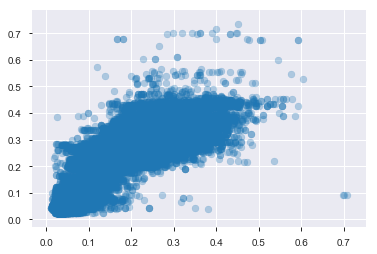

In [32]:
plt.scatter(ensemble["is_click_prev"], ensemble["is_click_curr"], alpha=0.3)

In [20]:
prev_data.head()

impression_id  is_click
0  000109e6bf54b3b20e8547b6026bc355  0.168449
1  0001c82eb924a3dca30593bf7d8f2227  0.025192
2  00038787e666dbf59f419128a0ee3a66  0.069197
3  00044057f135cc6526be752ad83115f6  0.353554
4  0004bdb4af3099a24adffc7ff08803e7  0.025742

In [50]:
val_preidct = clf.predict(val_data.drop(columns=drop_cols))

In [277]:
len(train_data) + len(test_data)

328284

In [280]:
X_train[X_train["user_id"].isnull()].shape

(1639, 45)

In [294]:
X_train.head()

impression_id  is_click  user_id  app_code  \
0  c4ca4238a0b923820dcc509a6f75849b         0  87862.0     422.0   
1  45c48cce2e2d7fbdea1afc51c7c6ad26         1  63410.0     467.0   
2  70efdf2ec9b086079795c442636b55fb         0  71748.0     259.0   
3  8e296a067a37563370ded05f5a3bf3ec         0  69209.0     244.0   
4  182be0c5cdcd5072bb1864cdee4d3d6e         0  62873.0     473.0   

     os_version  is_4G  train_flag  session_id device_type  items  \
0           old    0.0         1.0    190710.0     android    1.0   
1        latest    1.0         1.0    343558.0     android    1.0   
2  intermediate    1.0         1.0    658178.0     android    1.0   
3        latest    1.0         1.0    358781.0     android    4.0   
4        latest    0.0         1.0    809094.0     android    1.0   

           ...           sessions_cnt  category1_agg_cnt  \
0          ...                    1.0                1.0   
1          ...                    5.0                7.0   
2          ...                    1.0                1.0   
3          ...                    3.0               11.0   
4          ...                    7.0                9.0   

   category1_agg_nunique  category2_agg_cnt  category2_agg_nunique  \
0                    1.0                1.0                    1.0   
1                    2.0                7.0                    2.0   
2                    1.0                1.0                    1.0   
3                    5.0               11.0                    5.0   
4                    6.0                9.0                    7.0   

   category3_agg_cnt  category3_agg_nunique  product_type_agg_cnt  \
0                1.0                    1.0                   1.0   
1                7.0                    2.0                   7.0   
2                1.0                    1.0                   1.0   
3               11.0                    5.0                  11.0   
4                9.0                    8.0                   9.0   

   product_type_agg_nunique  sess_len_max_minutes  
0                       1.0                   0.0  
1                       3.0                   3.0  
2                       1.0                   0.0  
3                       6.0                  17.0  
4                       8.0                   4.0  

[5 rows x 45 columns]

In [116]:
feature_data_filtered["product_time_lag"].describe()

count                   12439851
mean     24 days 14:24:28.545163
std      15 days 17:40:54.828373
min              0 days 00:01:00
25%             11 days 04:36:00
50%             23 days 08:08:00
75%             36 days 03:49:00
max             64 days 14:39:00
Name: product_time_lag, dtype: object

In [117]:
min_timelag = feature_data_filtered.groupby(["user_id", "impression_time"])["product_time_lag"].min()

user_id
63410   21 days 12:47:00
87862   26 days 05:49:00
Name: product_time_lag, dtype: timedelta64[ns]

For a given user, the gap between a product view and impression is on an average 23 - 24 days. 

In [ ]:
feature_data_filtered.groupby(["user_id", "impression_id"]).agg({"product_time_lag":[np.min, np.max],
                                                                "min_item_price":"min",
                                                                "max_item_price":"max",
                                                                "items":"sum", 
                                                                "category1":})